In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras.backend as K
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

mpl.rcParams['figure.figsize'] = (64, 26)
mpl.rcParams['axes.grid'] = False
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
# import tensorflow as tf

Num GPUs Available:  1


In [2]:
combined_pd=pd.read_pickle('./Dataset/combined_hr_monterrey.pkl')

In [3]:
combined_pd['Total']=combined_pd.Energy+combined_pd.Lost+combined_pd.Congestion

In [4]:
combined_pd.columns

Index(['Date', 'Timestamp', 'Energy', 'Lost', 'Congestion', 'Rate', 'Ending',
       'Holiday', 'dt', 'timezone', 'city_name', 'lat', 'lon', 'temp',
       'feels_like', 'temp_min', 'temp_max', 'pressure', 'sea_level',
       'grnd_level', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h',
       'rain_3h', 'snow_1h', 'snow_3h', 'clouds_all', 'weather_id',
       'weather_main', 'weather_description', 'weather_icon', 'Filter',
       'Total'],
      dtype='object')

In [5]:
#Based on EDA, I will choose the following features
features=['Total', 'Rate', 'Ending','feels_like','pressure','humidity','wind_speed','wind_deg']

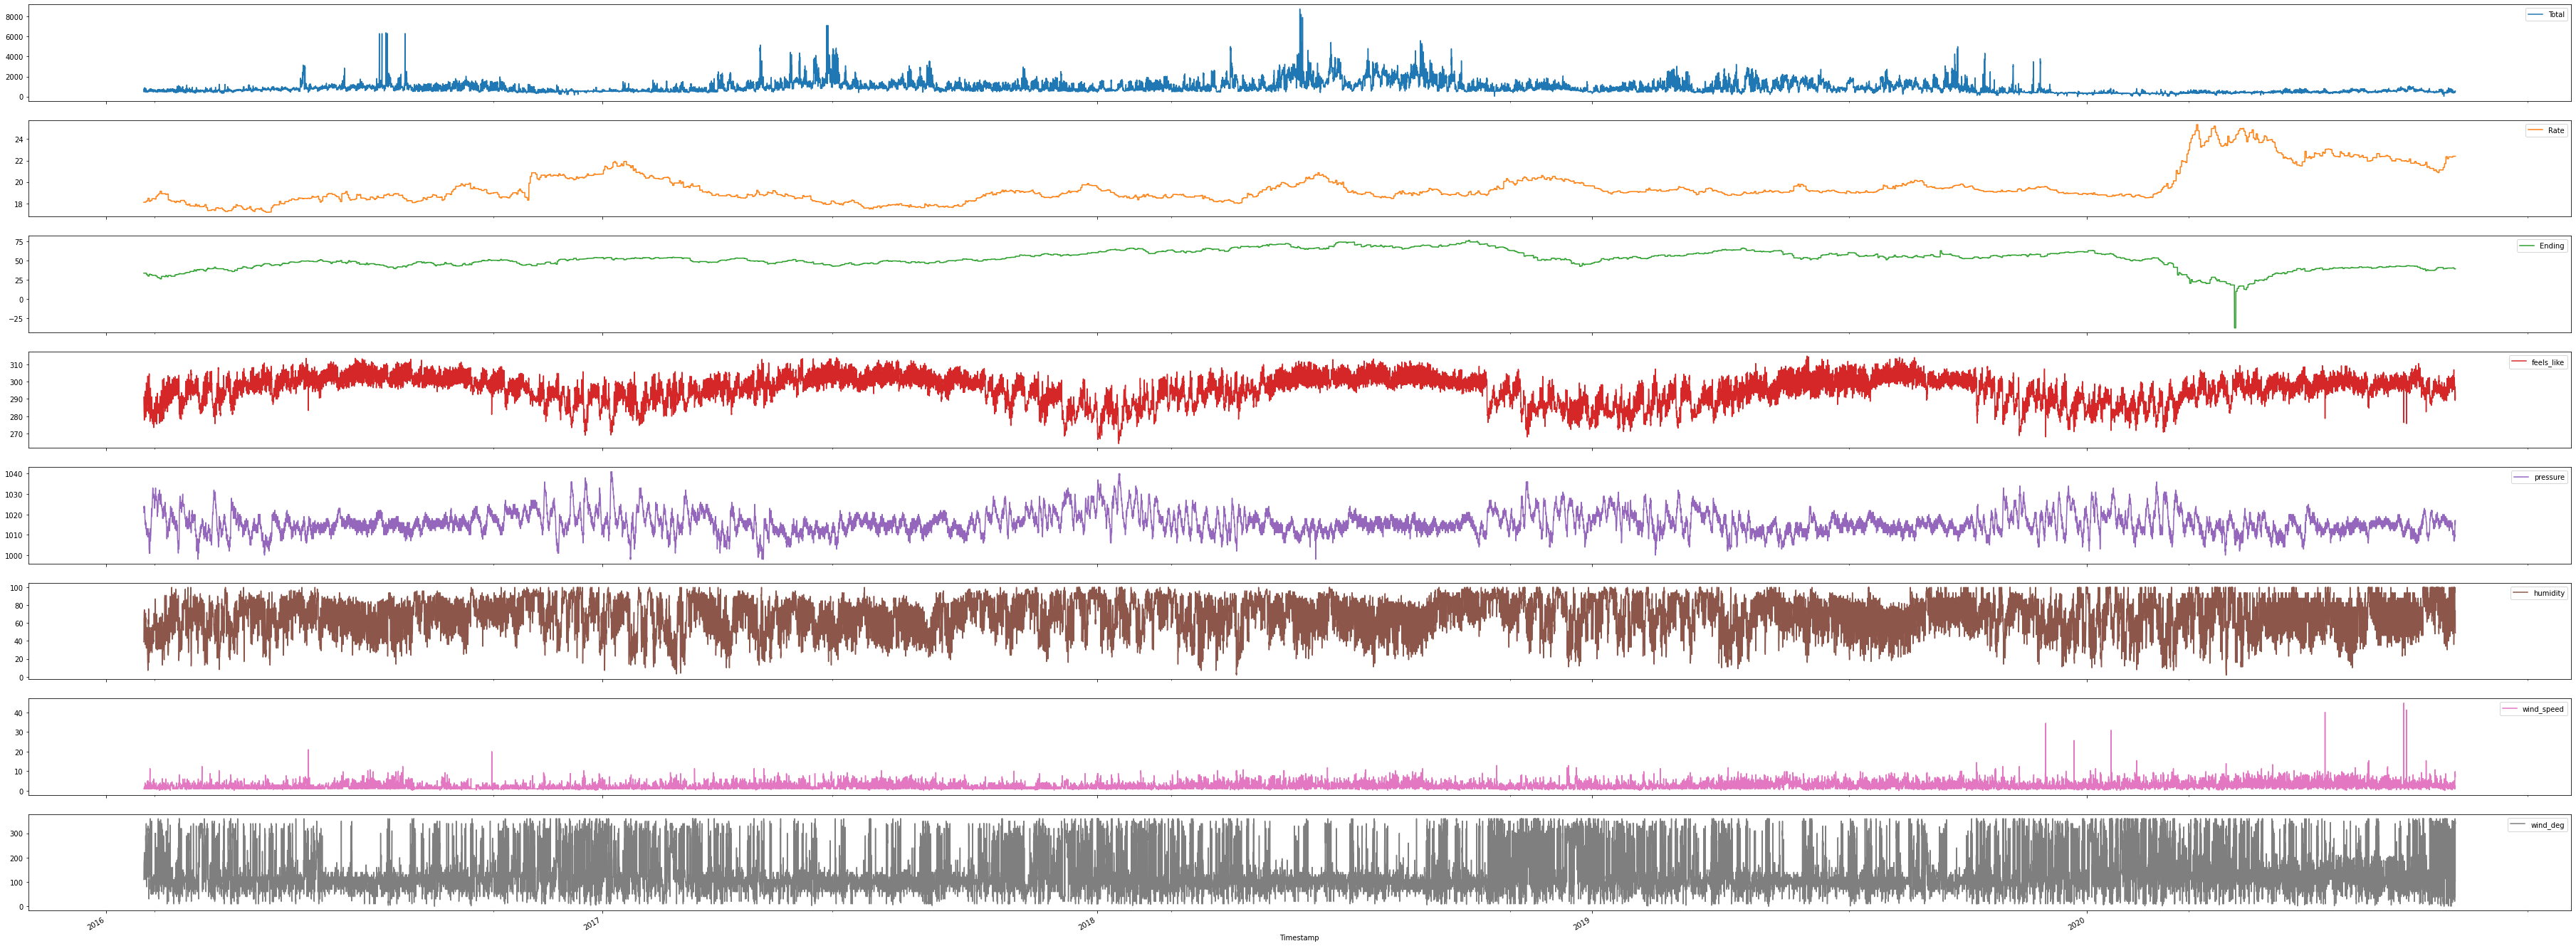

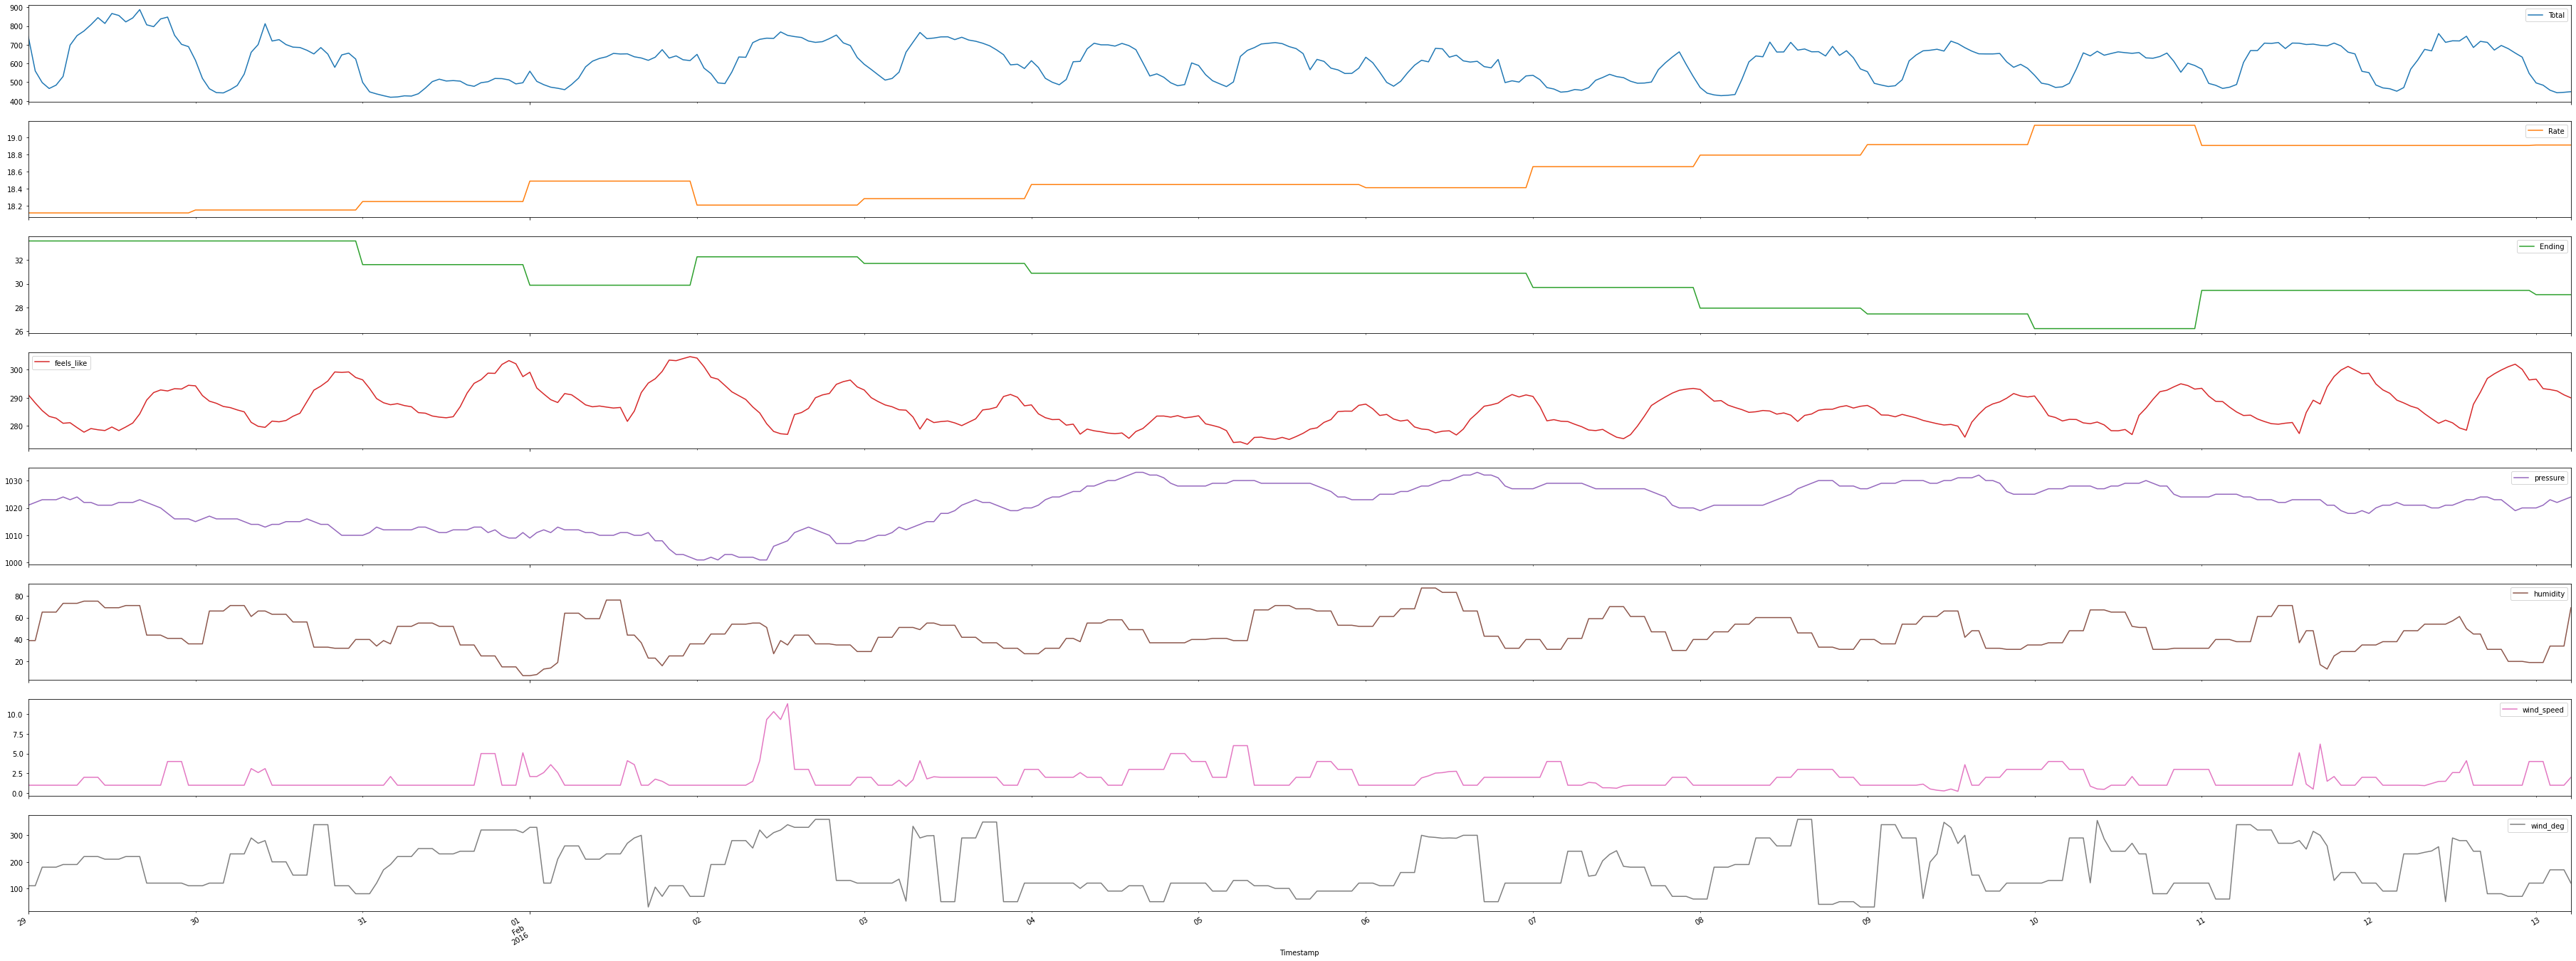

In [6]:
#Checking on evolution of features over time
plot_features=combined_pd[features]
plot_features.index=combined_pd['Timestamp']
_=plot_features.plot(subplots=True)

plot_features = combined_pd[features][:366]
plot_features.index = combined_pd['Timestamp'][:366]
_ = plot_features.plot(subplots=True)

<ipython-input-7-01c7e9e87529>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_features['Day_sin']=np.sin(combined_pd['Timestamp']*(2*np.pi/day))
<ipython-input-7-01c7e9e87529>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_features['Day_cos']=np.cos(combined_pd['Timestamp']*(2*np.pi/day))
<ipython-input-7-01c7e9e87529>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Text(0.5, 1.0, 'Time of week signal')

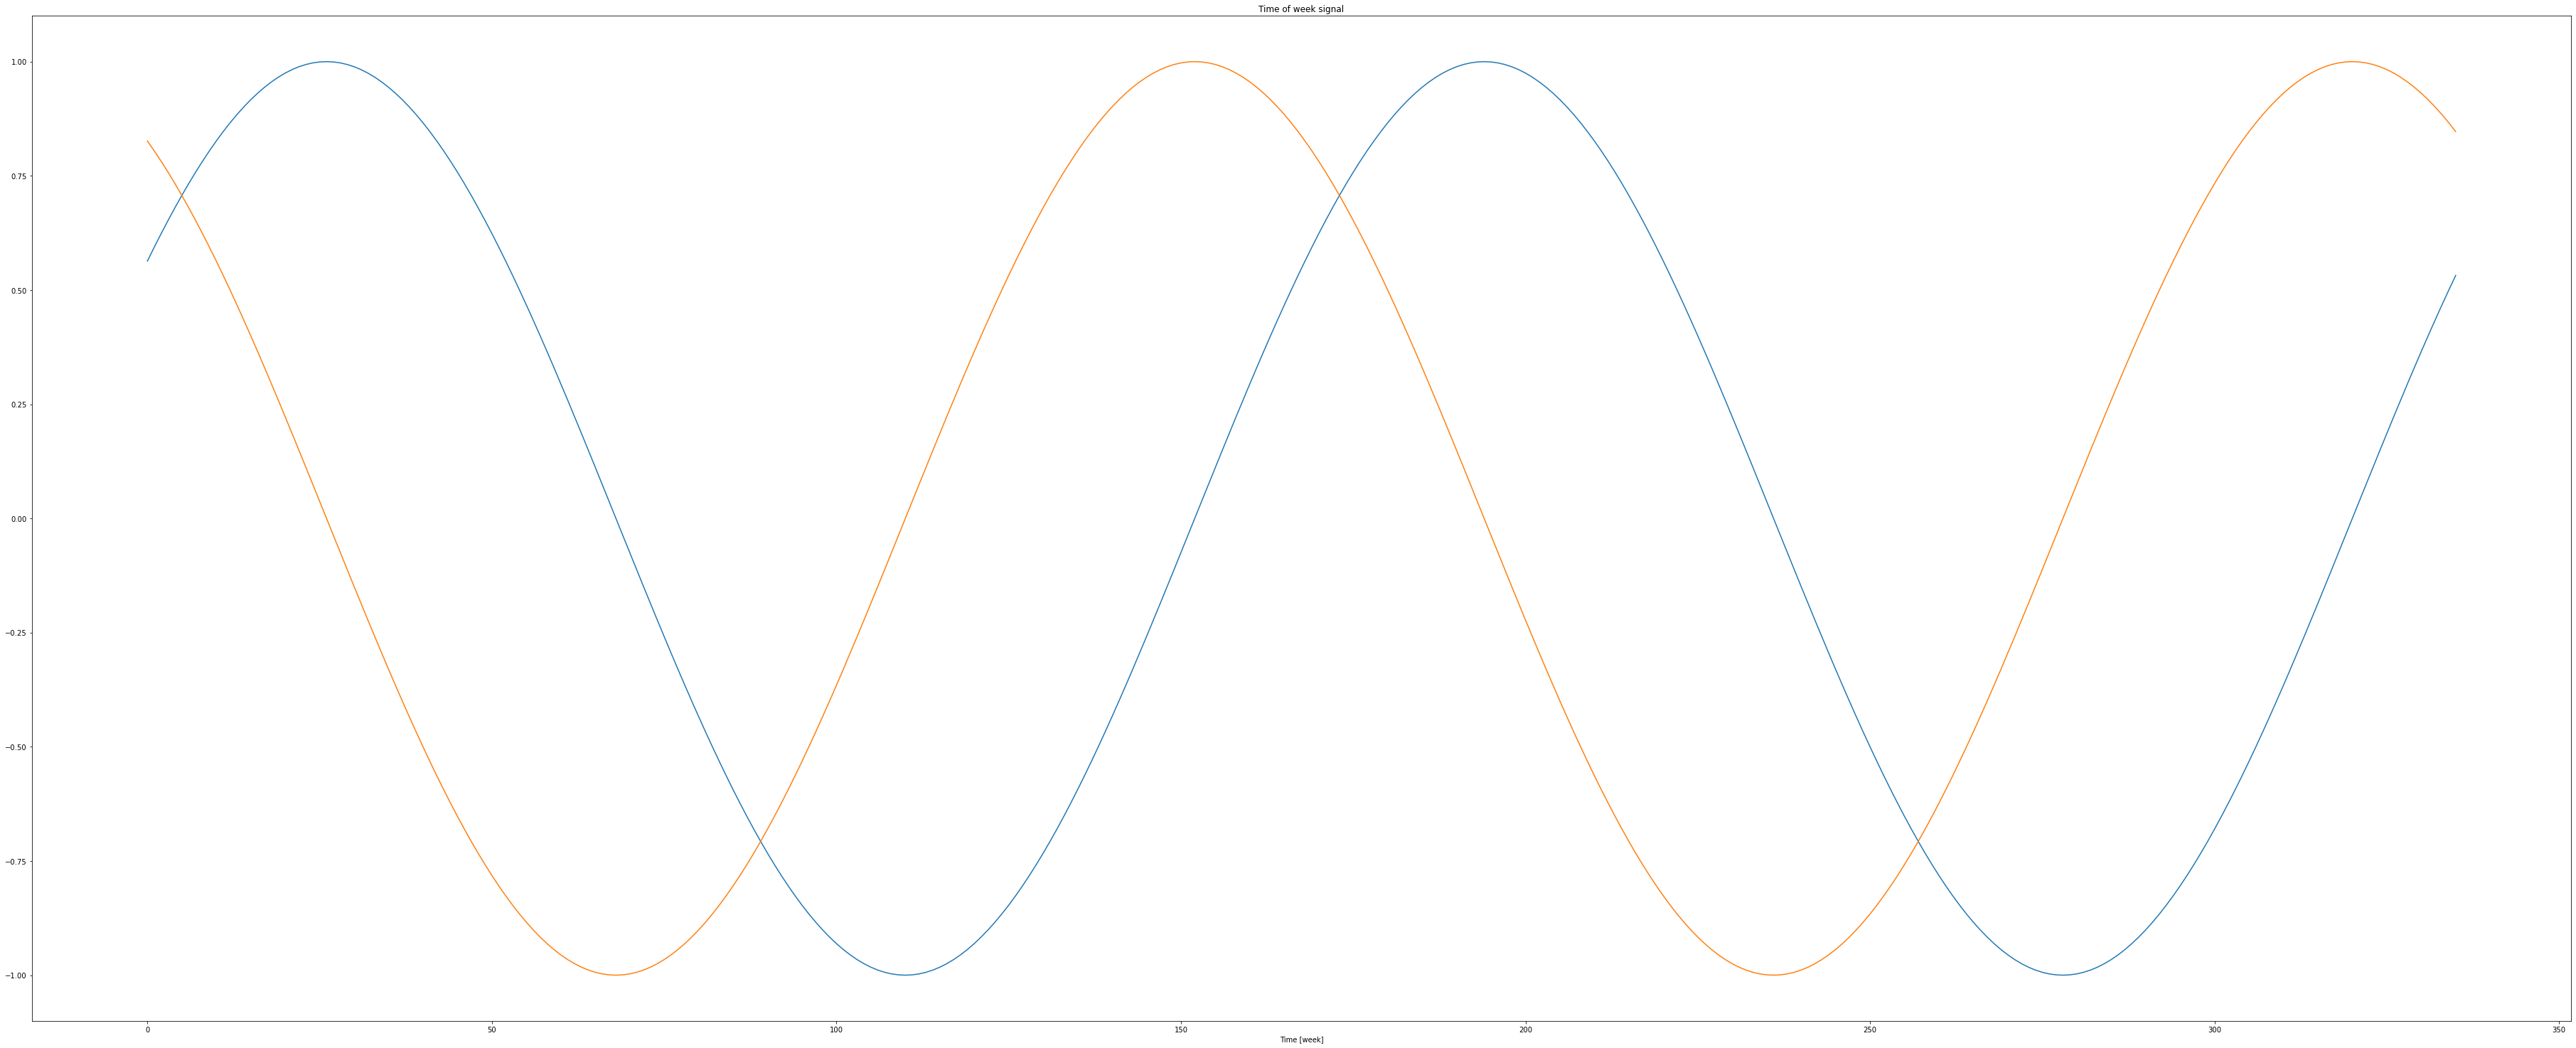

In [7]:
# Feature Engineering - Time
combined_pd['Timestamp']=combined_pd['Timestamp'].map(datetime.datetime.timestamp)
data_features=combined_pd[features]

day=60*60*24
week=7*day
year=day*365.25

data_features['Day_sin']=np.sin(combined_pd['Timestamp']*(2*np.pi/day))
data_features['Day_cos']=np.cos(combined_pd['Timestamp']*(2*np.pi/day))
data_features['Week_sin']=np.sin(combined_pd['Timestamp']*(2*np.pi/week))
data_features['Week_cos']=np.cos(combined_pd['Timestamp']*(2*np.pi/week))

plt.plot(np.array(data_features['Week_sin'])[:336])
plt.plot(np.array(data_features['Week_cos'])[:336])

plt.xlabel('Time [week]')
plt.title('Time of week signal')


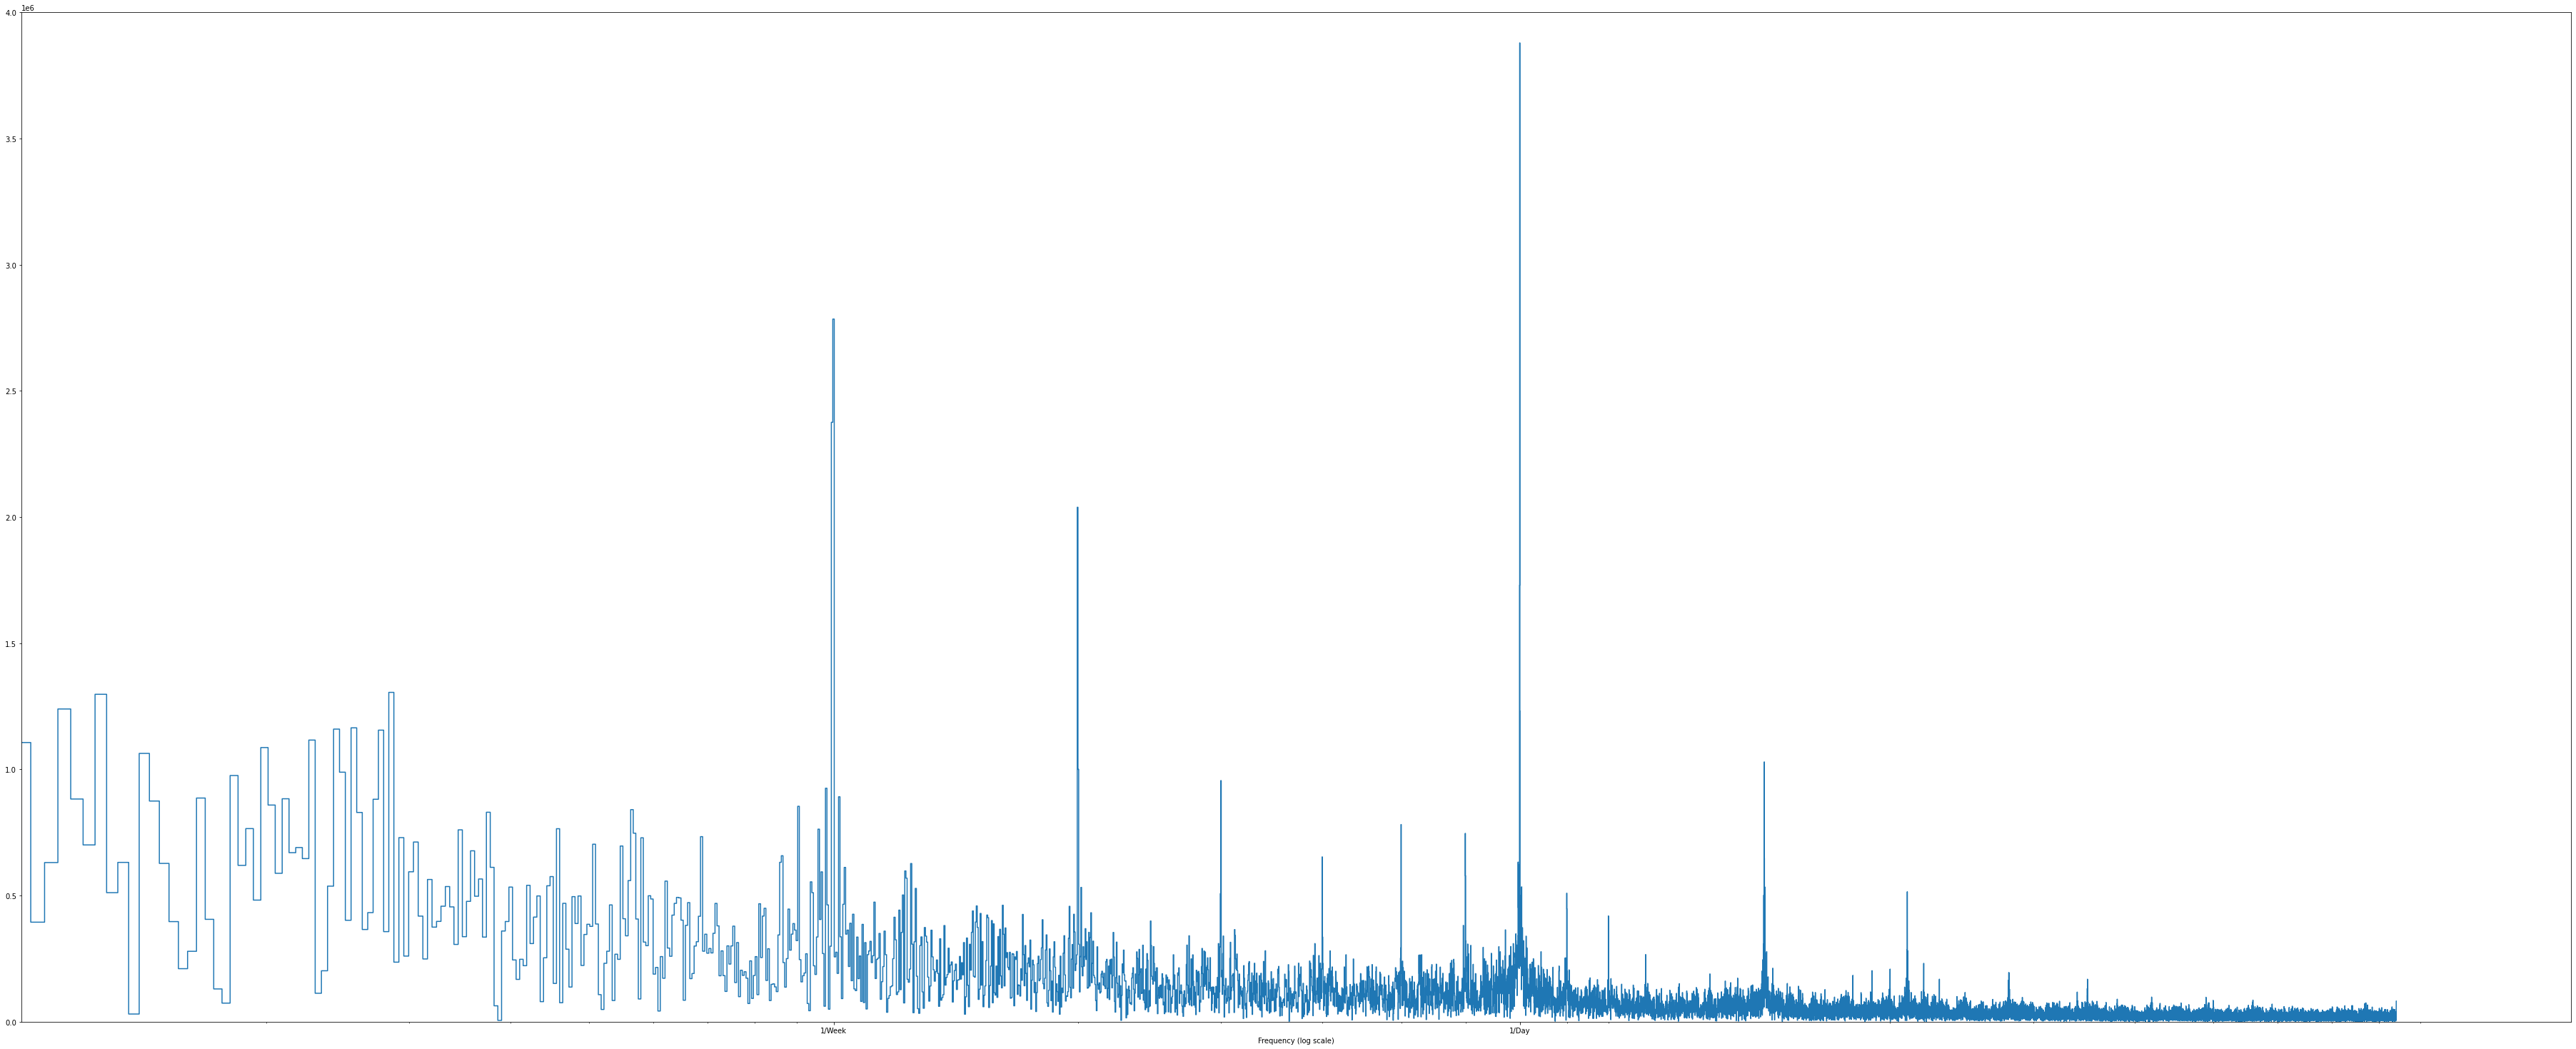

In [8]:
#Exploring importance of frequency features
fft = tf.signal.rfft(data_features['Total'])
f_per_dataset = np.arange(0, len(fft))

n_samples_d = len(data_features['Total'])
days_per_week = 7
weeks_per_dataset=n_samples_d/24/7


f_per_week = f_per_dataset/weeks_per_dataset
plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 4000000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, days_per_week], labels=['1/Week', '1/Day'])
_ = plt.xlabel('Frequency (log scale)')

<ipython-input-9-5b92cacb31fd>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_features['Wx'] = ws*np.cos(wd_rad)
<ipython-input-9-5b92cacb31fd>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_features['Wy'] = ws*np.sin(wd_rad)


(-13.715007747359316,
 35.68024663591888,
 -24.15010035419784,
 44.119387334946914)

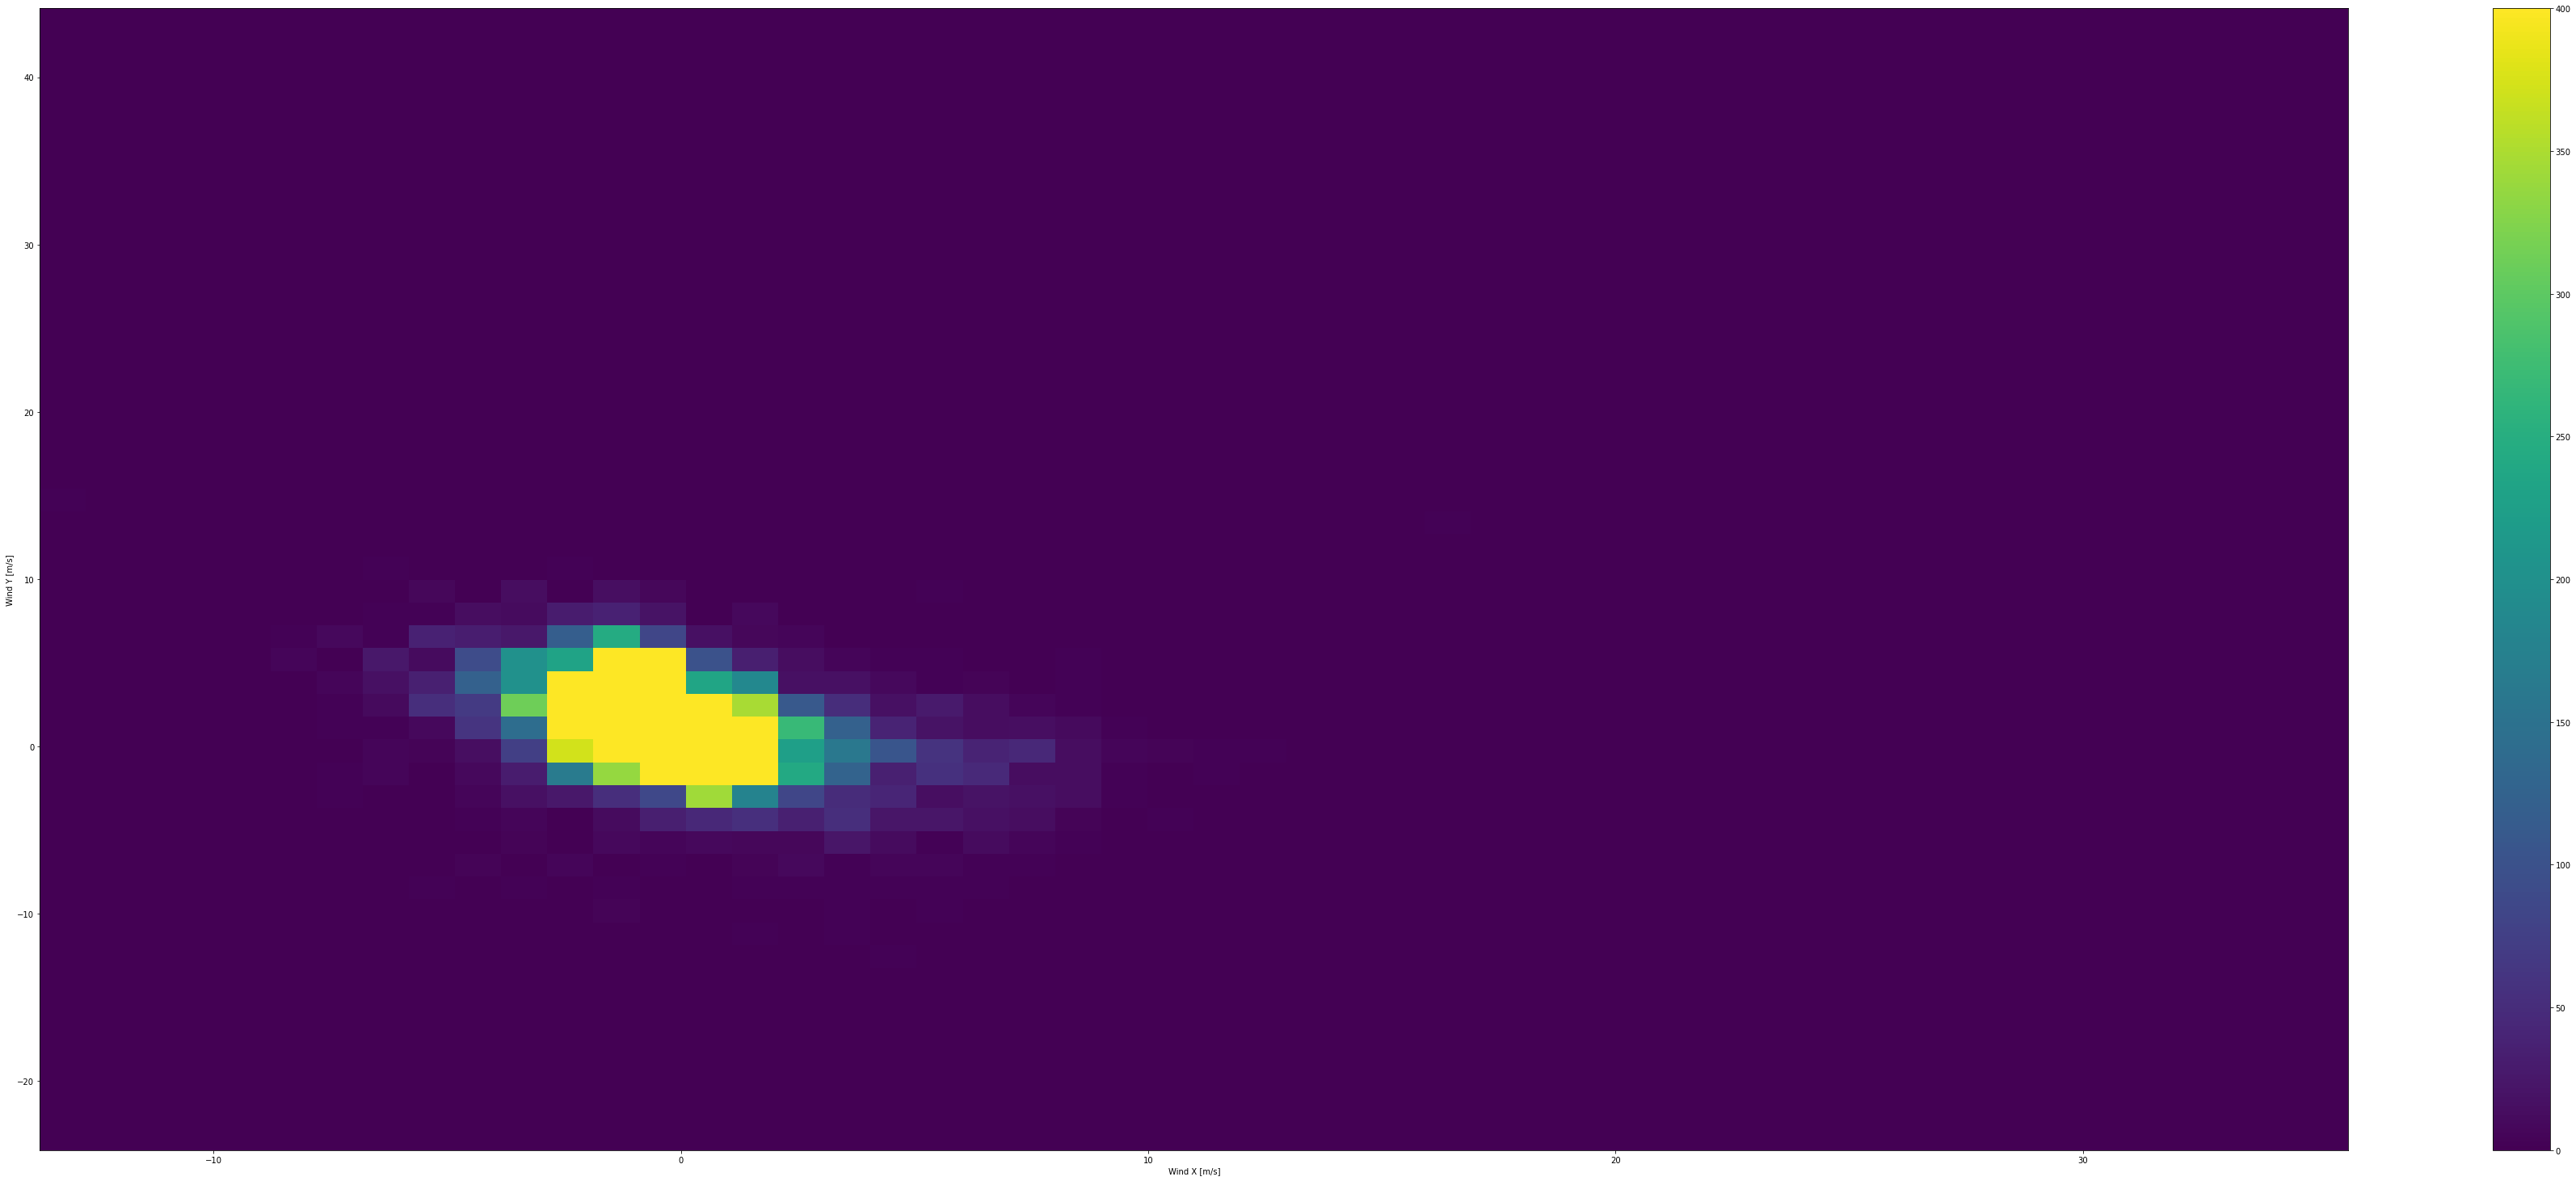

In [9]:
# Feature Engineering Wind Velocity Vectors
ws = data_features.pop('wind_speed')

# Convert to radians.
wd_rad = data_features.pop('wind_deg')*np.pi / 180

# Calculate the wind x and y components.
data_features['Wx'] = ws*np.cos(wd_rad)
data_features['Wy'] = ws*np.sin(wd_rad)

plt.hist2d(data_features['Wx'], data_features['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [10]:
data_features

,Total,Rate,Ending,feels_like,pressure,humidity,Day_sin,Day_cos,Week_sin,Week_cos,Wx,Wy
0,744.87,18.1126,33.62,291.08,1021,39,-8.660254e-01,-5.000000e-01,0.563320,0.826239,-0.342020,9.396926e-01
1,560.36,18.1126,33.62,288.16,1022,39,-9.659258e-01,-2.588190e-01,0.593820,0.804598,-0.342020,9.396926e-01
2,497.98,18.1126,33.62,285.46,1023,65,-1.000000e+00,-9.452702e-12,0.623490,0.781831,-1.000000,1.224647e-16
3,466.43,18.1126,33.62,283.41,1023,65,-9.659258e-01,2.588190e-01,0.652287,0.757972,-1.000000,1.224647e-16
4,484.60,18.1126,33.62,282.76,1023,65,-8.660254e-01,5.000000e-01,0.680173,0.733052,-1.000000,1.224647e-16
...,...,...,...,...,...,...,...,...,...,...,...,...
40915,488.26,22.4012,39.29,289.16,1017,56,2.588190e-01,-9.659258e-01,-0.757972,-0.652287,9.208988,-3.351797e+00
40916,539.13,22.4012,39.29,294.50,1015,74,1.204628e-11,-1.000000e+00,-0.781831,-0.623490,-1.337091,7.583020e+00
40917,571.03,22.4012,39.29,291.22,1016,56,-2.588190e-01,-9.659258e-01,-0.804598,-0.593820,8.075424,-1.423915e+00
40918,564.02,22.4012,39.29,290.90,1017,49,-5.000000e-01,-8.660254e-01,-0.826239,-0.563320,7.235633,-2.633555e+00


In [11]:
#The above EDA shows that the weekly and daily frequencies are the most prominent cyclic features
#data_features=data_features.drop(['Year_sin','Year_cos'],axis=1)

column_indices={name:i for i,name in enumerate(data_features.columns)}
n=len(data_features)
train_df=data_features[:int(n*0.7)]
val_df=data_features[int(n*0.7):int(n*0.9)]
test_df=data_features[int(n*0.9):]

num_features= data_features.shape[1]


In [12]:
data_features

,Total,Rate,Ending,feels_like,pressure,humidity,Day_sin,Day_cos,Week_sin,Week_cos,Wx,Wy
0,744.87,18.1126,33.62,291.08,1021,39,-8.660254e-01,-5.000000e-01,0.563320,0.826239,-0.342020,9.396926e-01
1,560.36,18.1126,33.62,288.16,1022,39,-9.659258e-01,-2.588190e-01,0.593820,0.804598,-0.342020,9.396926e-01
2,497.98,18.1126,33.62,285.46,1023,65,-1.000000e+00,-9.452702e-12,0.623490,0.781831,-1.000000,1.224647e-16
3,466.43,18.1126,33.62,283.41,1023,65,-9.659258e-01,2.588190e-01,0.652287,0.757972,-1.000000,1.224647e-16
4,484.60,18.1126,33.62,282.76,1023,65,-8.660254e-01,5.000000e-01,0.680173,0.733052,-1.000000,1.224647e-16
...,...,...,...,...,...,...,...,...,...,...,...,...
40915,488.26,22.4012,39.29,289.16,1017,56,2.588190e-01,-9.659258e-01,-0.757972,-0.652287,9.208988,-3.351797e+00
40916,539.13,22.4012,39.29,294.50,1015,74,1.204628e-11,-1.000000e+00,-0.781831,-0.623490,-1.337091,7.583020e+00
40917,571.03,22.4012,39.29,291.22,1016,56,-2.588190e-01,-9.659258e-01,-0.804598,-0.593820,8.075424,-1.423915e+00
40918,564.02,22.4012,39.29,290.90,1017,49,-5.000000e-01,-8.660254e-01,-0.826239,-0.563320,7.235633,-2.633555e+00


In [13]:
#Data normalization
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [14]:
train_mean

Total         1066.444949
Rate            18.983134
Ending          54.022061
feels_like     295.112323
pressure      1016.545350
humidity        67.419076
Day_sin         -0.000163
Day_cos          0.000212
Week_sin         0.001562
Week_cos        -0.001023
Wx              -0.070782
Wy               1.287389
dtype: float64

In [15]:
train_std

Total         638.168254
Rate            0.882050
Ending          9.875657
feels_like      8.362288
pressure        5.600516
humidity       20.231055
Day_sin         0.707119
Day_cos         0.707119
Week_sin        0.707117
Week_cos        0.707118
Wx              1.513531
Wy              1.864332
dtype: float64

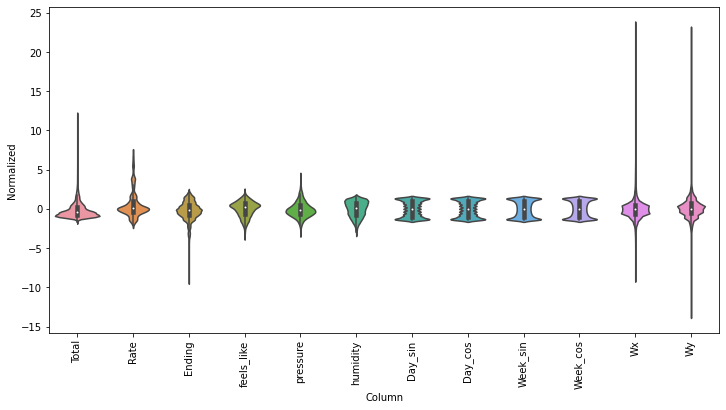

In [16]:
df_std = (data_features - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(data_features.keys(), rotation=90)

In [17]:
#Data Pipeline
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [18]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [19]:
def plot(self, model=None, plot_col='Total', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normalized]')
    plt.plot(self.input_indices[264:], inputs[n, 264:, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.plot(self.label_indices, labels[n, :],
                label='Labels', marker='.', zorder=-10)
#     plt.scatter(self.label_indices, labels[n, :, label_col_index],
#                 edgecolors='k', label='Labels', c='#2ca02c', s=8)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=16)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [hour]')

WindowGenerator.plot = plot

In [20]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [21]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.test))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [22]:
def custom_loss(y_actual,y_predict):
    y_actual=y_actual[:,:,0]
    y_predict=y_predict[:,:,0]
    loss=K.mean(K.square(y_actual-y_predict)*K.abs((y_actual-y_predict)/y_actual))/10
    return loss

In [23]:
def custom_loss(y_actual,y_predict):
    y_actual=y_actual[:,:,0]
    y_predict=y_predict[:,:,0]
    loss=K.mean(K.square(y_actual-y_predict))/10
    return loss

In [24]:
def custom_mape(y_actual,y_predict):
    y_actual=y_actual[:,:,0]
    y_predict=y_predict[:,:,0]
    loss=K.mean(K.abs((y_actual-y_predict)/y_actual))
    return loss

In [38]:
checkpoint_path = "./Models/HLMP_AutoRegress"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [24]:
MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=1):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=custom_loss,
                optimizer=tf.optimizers.Adam(),
                metrics=[custom_mape])
#  
#   model.compile(loss=tf.keras.losses.MeanSquaredError(),
#                 optimizer=tf.optimizers.Adam(),
#                 metrics=[tf.metrics.MeanAbsoluteError()])


  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                     callbacks=[cp_callback])

#   history = model.fit(window.train, epochs=MAX_EPOCHS,
#                       validation_data=window.val,
#                       callbacks=[early_stopping])
  return history

In [34]:
#Evaluating model performance using MAE in local currency
def check_performance(model,window):
    predictions=model.predict(window.test)
    targets=tfds.as_numpy(window.test, graph=None)
    target_array=[]
    for element in targets:
        if len(target_array)==0:
            target_array=element[1][:,:,0]
            
        else:
            target_array=np.concatenate((target_array,element[1][:,:,0]),axis=0)
    try:
        pred_array=predictions[:,:,0]
    except:
        pred_array=predictions
    MAE=np.absolute(pred_array-target_array)
    MAPE=np.absolute(((target_array*train_std[0])-pred_array*train_std[0])/(target_array*train_std[0]+train_mean[0]))
    print('ME= ',(pred_array-target_array).sum()/pred_array.shape[0]/pred_array.shape[1]*train_std[0])
    print('MAE= ',MAE.sum()/pred_array.shape[0]/pred_array.shape[1]*train_std[0])
    print('MAPE= ',MAPE.sum()/pred_array.shape[0]/pred_array.shape[1])

In [27]:
##Model Development
multi_val_performance = {}
multi_performance = {}
OUT_STEPS = 168
multi_window = WindowGenerator(input_width=OUT_STEPS*2,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,)
                               
#label_columns=['Total']
# multi_window.plot()
multi_window

Total window size: 504
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

In [29]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs[:, -OUT_STEPS:, 0]

repeat_baseline = RepeatBaseline()


In [32]:
check_performance(repeat_baseline,multi_window)

ME=  -1.5546402111134718
MAE=  140.66513738163985
MAPE=  0.29805098498719634


In [ ]:
#### Baseline CNN fixed width projection
CONV_WIDTH = 336
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(3360, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

MAX_EPOCHS = 1
history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

In [ ]:
check_performance(multi_conv_model,multi_window)

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.Dense(OUT_STEPS,activation='relu'),
    tf.keras.layers.Dense(60,activation='relu'),
    tf.keras.layers.Dense(30,activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1,activation='relu'),
    
    # Shape => [batch, out_steps, features]
#     tf.keras.layers.Reshape([OUT_STEPS])
])

MAX_EPOCHS = 10

history = compile_and_fit(multi_lstm_model, multi_window)

# IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [ ]:
#LSTM multi-step model:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.Dense(OUT_STEPS,activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS,activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS,activation='relu'),
   
    tf.keras.layers.Dense(OUT_STEPS*1,use_bias=False),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
    # Shape => [batch, out_steps, features]
#     tf.keras.layers.Reshape([OUT_STEPS])
])
MAX_EPOCHS = 1

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [ ]:
MAX_EPOCHS = 1
history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [ ]:
check_performance(multi_lstm_model,multi_window)

In [ ]:
check_performance(multi_lstm_model,multi_window)

In [ ]:
#LSTM multi-step model:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(OUT_STEPS*3, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(OUT_STEPS*3,activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS*2,activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS*1,activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS),
    # Shape => [batch, out_steps, features]
#     tf.keras.layers.Reshape([OUT_STEPS])
])
MAX_EPOCHS = 1

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [ ]:
multi_window.plot(multi_lstm_model)

In [ ]:
#LSTM multi-step model:
multi_lstm_model2 = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstRepeatm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(OUT_STEPS*num_features, return_sequences=False),
    # Shape => [batch, out_steps*features]
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(OUT_STEPS*num_features,activation='relu',),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(OUT_STEPS*num_features,activation='relu',),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
MAX_EPOCHS = 1
history = compile_and_fit(multi_lstm_model2, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model2.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model2.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model2)

In [ ]:
check_performance(multi_lstm_model,multi_window)

In [ ]:
check_performance(multi_lstm_model2,multi_window)

In [ ]:
multi_lstm_model.save('./Models/HLMP_LSTM')

In [ ]:
#GRU multi-step model:
multi_gru_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.GRU(512, return_sequences=False,dropout=0.1,
                         recurrent_dropout=0.1),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
MAX_EPOCHS = 1
history = compile_and_fit(multi_gru_model, multi_window)

IPython.display.clear_output()

multi_val_performance['GRU'] = multi_gru_model.evaluate(multi_window.val)
multi_performance['GRU'] = multi_gru_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_gru_model)

In [ ]:
check_performance(multi_gru_model,multi_window)

In [25]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [28]:
feedback_model = FeedBack(units=680, out_steps=OUT_STEPS)

In [29]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [42]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 12])

In [30]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [44]:
Repeat = 10
for epoch in range(Repeat):
    MAX_EPOCHS=1
    history = compile_and_fit(feedback_model, multi_window)
    check_performance(feedback_model,multi_window)

880/880 [==============================] - ETA: 0s - loss: 0.0882 - custom_mape: 2.3154
Epoch 00001: saving model to ./Models/HLMP_AutoRegress
880/880 [==============================] - 182s 207ms/step - loss: 0.0882 - custom_mape: 2.3154 - val_loss: 0.0707 - val_custom_mape: 3.2495
ME=  269.02013186767084
MAE=  278.6559133232214
MAPE=  0.6544902724429141
880/880 [==============================] - ETA: 0s - loss: 0.0603 - custom_mape: 2.2882
Epoch 00001: saving model to ./Models/HLMP_AutoRegress
880/880 [==============================] - 183s 208ms/step - loss: 0.0603 - custom_mape: 2.2882 - val_loss: 0.0813 - val_custom_mape: 3.8139
ME=  87.8688991196359
MAE=  157.71682517480508
MAPE=  0.3580473912102456
880/880 [==============================] - ETA: 0s - loss: 0.0428 - custom_mape: 2.4665
Epoch 00001: saving model to ./Models/HLMP_AutoRegress
880/880 [==============================] - 183s 208ms/step - loss: 0.0428 - custom_mape: 2.4665 - val_loss: 0.1012 - val_custom_mape: 3.6398
M

KeyboardInterrupt: 

In [ ]:
Repeat = 5
for epoch in range(Repeat):
    MAX_EPOCHS=1
    history = compile_and_fit(feedback_model, multi_window)
    check_performance(feedback_model,multi_window)

In [ ]:
Repeat = 10
for epoch in range(Repeat):
    MAX_EPOCHS=1
    history = compile_and_fit(feedback_model, multi_window)
    check_performance(feedback_model,multi_window)

In [ ]:
def print_performance():
    return check_performance(feedback_model2,multi_window)

In [45]:
feedback_model2 = FeedBack(units=680, out_steps=OUT_STEPS)

In [32]:
feedback_model.load_weights('./Models/HLMP_AutoRegress')

In [35]:
check_performance(feedback_model,multi_window)

ME=  -10.022346821033944
MAE=  112.71077221272822
MAPE=  0.23920006277448289


In [53]:
check_performance(feedback_model2,multi_window)

ME=  -10.022345787433945
MAE=  112.86071863157264
MAPE=  0.23903283864221367


In [ ]:
feedback_model.save('./Models/HLMP_AutoRegress')

In [ ]:
feedback_model2 = FeedBack(units=680, out_steps=OUT_STEPS)
history = compile_and_fit(feedback_model2, multi_window)

In [ ]:
feedback_model2.load_model('./Models/HLMP_AutoRegress')